In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, get_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import pennylane_PQC_RZRXRZ_unique, qiskit_PQC_RZRXRZ_unique, qiskit_PQC_RXRZ_unique

from simulator.simulate import get_ideal_data_state, get_ideal_data_superpos, run_circuit_pennylane
from models.pennylane_models import SimplePennylaneQuantumStateModel
from models.noise_models import BitPhaseFlipNoise
from circuits.generate_circuits import GetGHZCircuitsForModel
from utils.loss_functions import QuantumFidelityLoss

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 3
INPUT_BITS = '11000'
EPOCHS = 2
# fakeVigo2_backend = FakeVigoV2()
# fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
# noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)
pqc_arch = pennylane_PQC_RZRXRZ_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = SimplePennylaneQuantumStateModel(
    num_qubits= NUM_QUBITS, num_params=NUM_QUBITS*3, pqc_arch_func=pqc_arch,   
    )

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
    )



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.05)
loss_fn = QuantumFidelityLoss()
# loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_state(NUM_QUBITS, num_vals=int(1000))
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 1000/1000 [00:00<00:00, 1005.31it/s]

32


In [9]:
param_list_epoch = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []
    epoch_param_snapshots = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        circuit = ghz_circuit_gen.get_noisy_model_circuit_params(params)
        measured = pqc_model(circuit=circuit)

        ideal = ideal.to(torch_device)
        measured = measured.to(torch_device)

        # print(ideal)
        # print(measured)

        # Compute fidelity loss
        # print(ideal)
        # print(measured)
        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out

        loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        epoch_param_snapshots.append(raw_param_values)
        epoch_loss_list.append(loss.item())

        data_iterator.set_postfix_str(f"Loss: {loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            # bounded = pqc_model.raw_params.detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            # print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")

# Optional: print debug stats
        # if enable_debug_logs and step == len(data_iterator) - 1:
        #     print(circuit.draw())
        #     print(measured)
        #     print(ideal)
        #     print(loss)

    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)
    param_list_epoch.extend(np.array(epoch_param_snapshots))

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

        


 Starting Epoch 1


  1%|          | 11/1000 [00:00<00:29, 34.00it/s, Loss: 9.8624e-01]

	Step 0, grad norm: 9.6291e-03
	Raw param range: [-17.865, 7.099]


100%|██████████| 1000/1000 [00:13<00:00, 75.06it/s, Loss: 3.9175e-02]


Epoch 1 complete: avg loss = 1.3293e-01

 Starting Epoch 2


  0%|          | 5/1000 [00:00<00:20, 48.86it/s, Loss: 6.0515e-02]

	Step 0, grad norm: 7.7057e-02
	Raw param range: [-18.696, 6.451]


100%|██████████| 1000/1000 [00:15<00:00, 65.11it/s, Loss: 4.8409e-02]

Epoch 2 complete: avg loss = 4.7834e-02


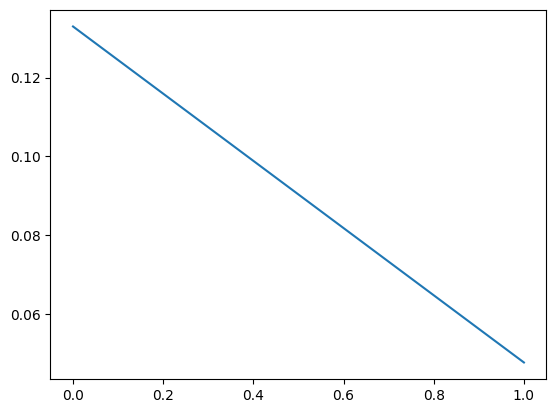

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
print(pqc_model.raw_params)

Parameter containing:
tensor([ -9.1225,   6.4181,   2.7848,   6.1203,   6.0526,   0.0516,   2.9991,
         -6.1388,  -3.1198,   2.9074,  -5.1337,  -3.2557,  -6.4936,  -0.2402,
        -18.6567], requires_grad=True)


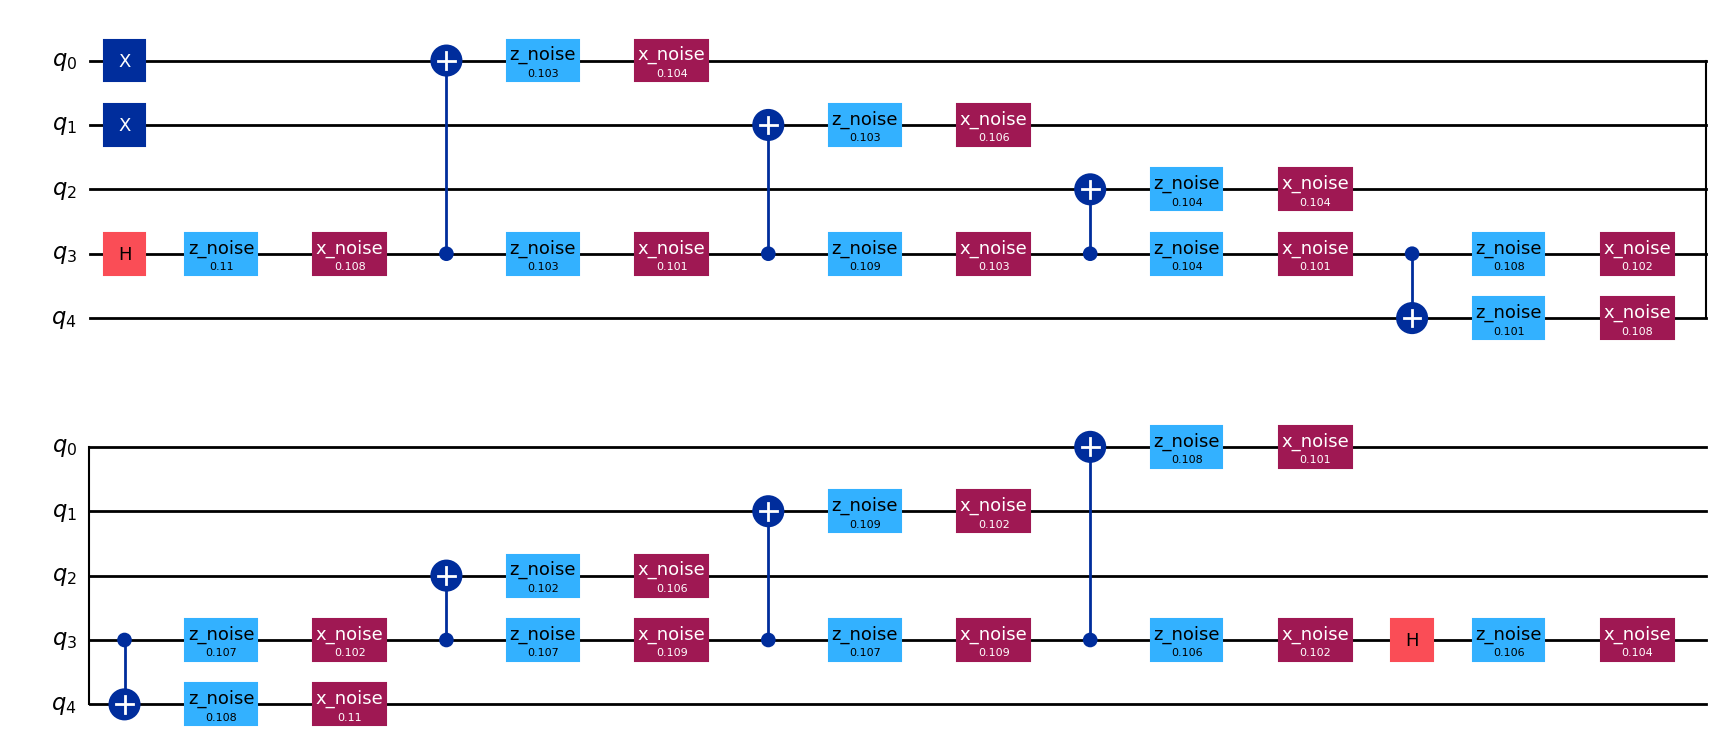

In [12]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

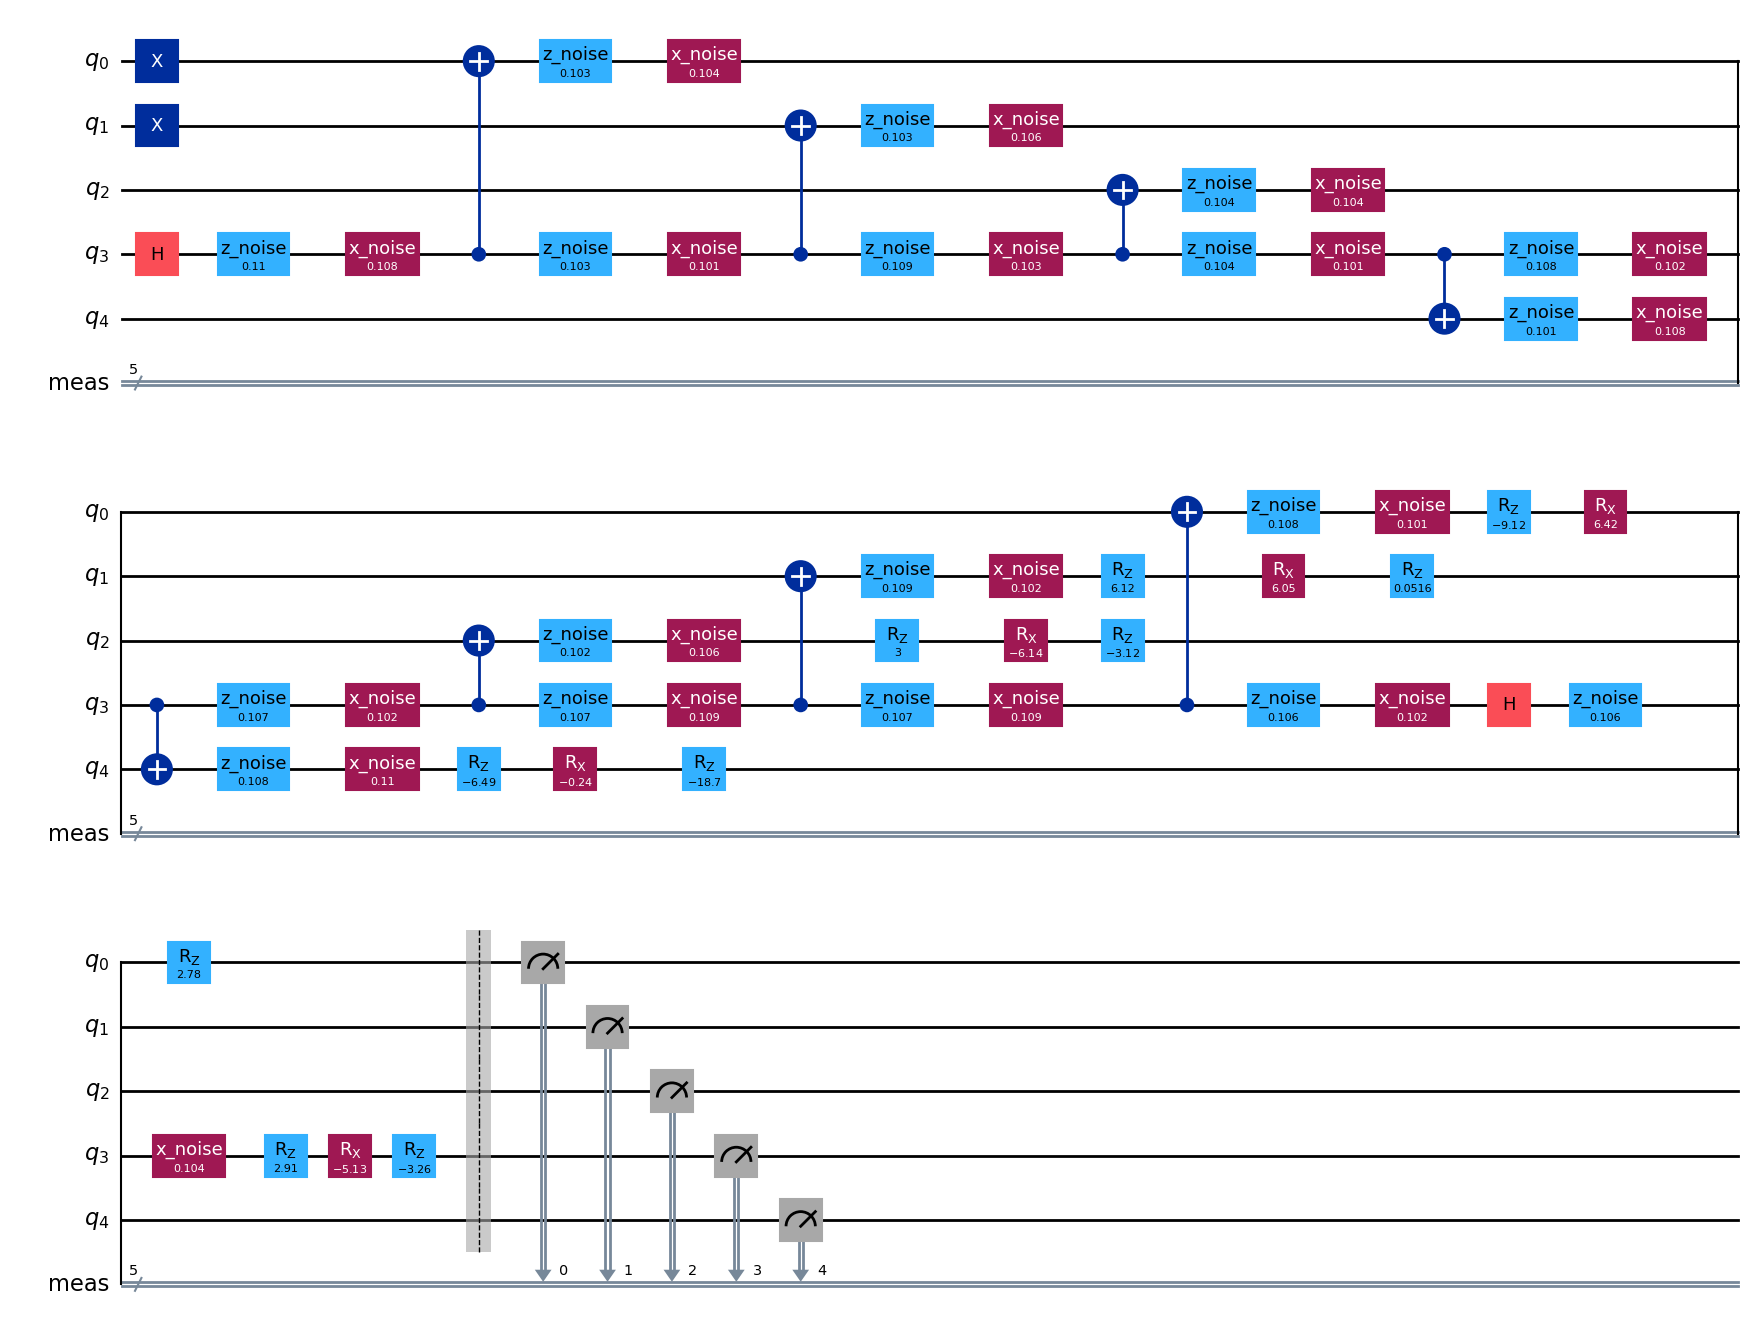

In [13]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, qiskit_PQC_RZRXRZ_unique)
noisy_model_circ_pqc.draw('mpl')

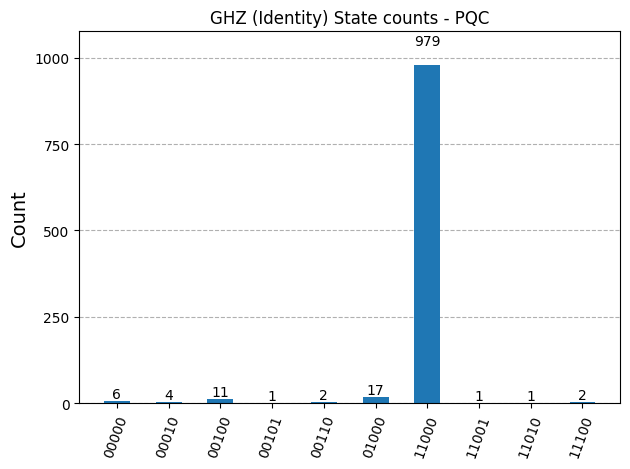

In [14]:
# transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
# result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
# counts = result.get_counts(transpiled_circ)

counts = run_circuit_pennylane(noisy_model_circ_pqc)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

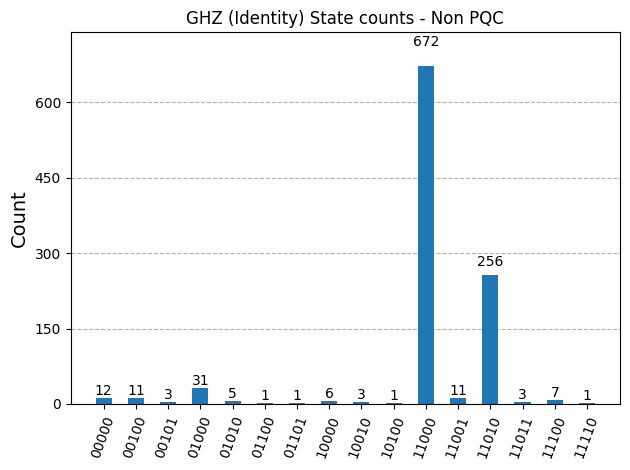

In [15]:
# transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
# result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
# counts = result.get_counts(transpiled_circ)


counts = run_circuit_pennylane(noisy_model_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

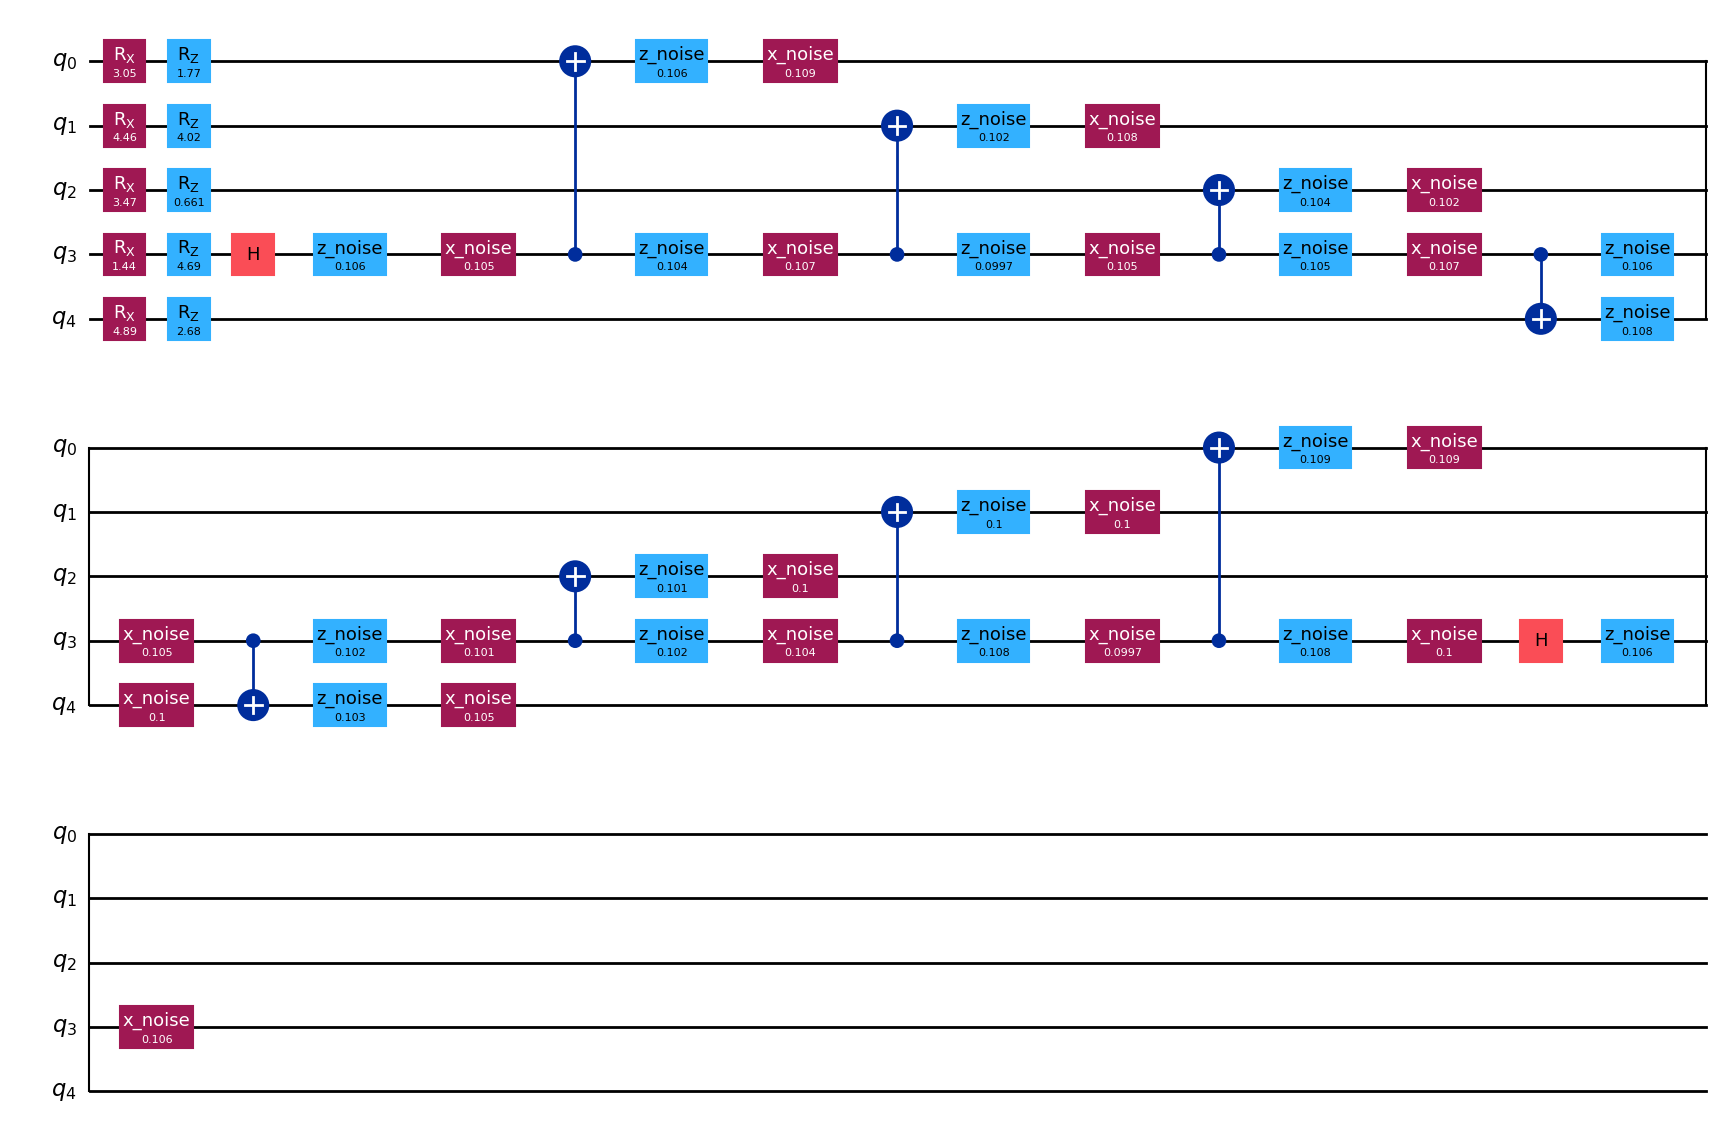

In [16]:
circuit.draw('mpl')

In [17]:
from qiskit.quantum_info import Statevector

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def state_fidelity(psi: torch.Tensor, phi: torch.Tensor) -> torch.Tensor:
    """
    Compute fidelity F = |⟨ψ|φ⟩|² between two normalized state vectors.

    Args:
        psi (torch.Tensor): Complex tensor of shape (2**n,) representing |ψ⟩
        phi (torch.Tensor): Complex tensor of shape (2**n,) representing |φ⟩

    Returns:
        torch.Tensor: Real-valued scalar fidelity
    """
    # Optional: normalize if needed
    psi = psi / torch.linalg.norm(psi)
    phi = phi / torch.linalg.norm(phi)

    overlap = torch.dot(torch.conj(psi), phi)
    return torch.abs(overlap) ** 2

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, num_vals=20, statevector=True)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, qiskit_PQC_RZRXRZ_unique)

    # counts_noisy = run_circuit_sampler(noisy_circ.measure_all(inplace=False))
    # counts_noisy_pqc = run_circuit_sampler(noisy_circ_pqc)

    # prob_i = counts_to_probs(ideal)
    # prob_n = counts_to_probs(counts_noisy)
    # prob_ne = counts_to_probs(counts_noisy_pqc)
    noi_out_st = torch.tensor(Statevector.from_instruction(noisy_circ.remove_final_measurements(inplace=False)).data)
    npqc_out_st = torch.tensor(Statevector.from_instruction(noisy_circ_pqc.remove_final_measurements(inplace=False)).data)
    
    

    fid_i_n = state_fidelity(ideal, noi_out_st)
    fid_i_ne = state_fidelity(ideal, npqc_out_st)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 1935.71it/s]


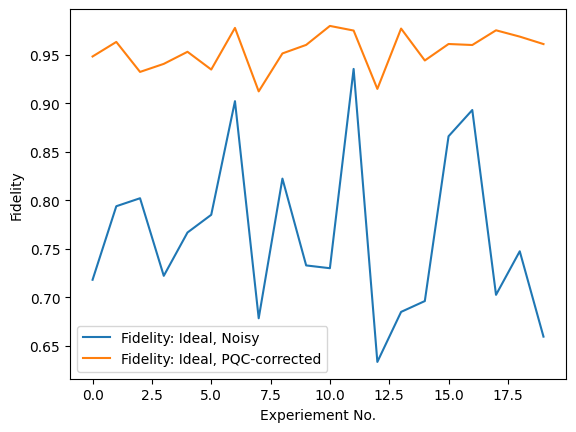

In [18]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [19]:
print(f"Avg Fidelity of noisy circuit: {np.mean(fid_noisy)}, Average Fidelity of noisy circ with PQC: {np.mean(fid_noisy_pqc)}")

Avg Fidelity of noisy circuit: 0.7637421404001236, Average Fidelity of noisy circ with PQC: 0.9545589627303472


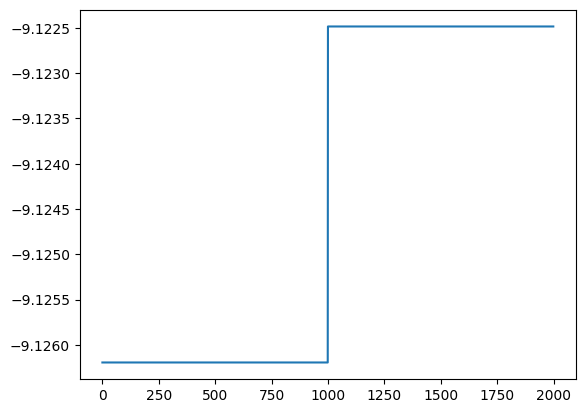

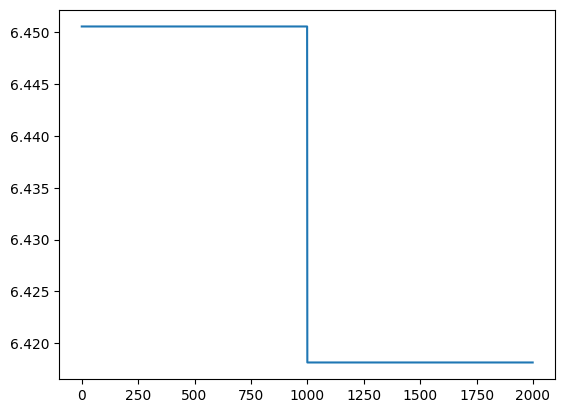

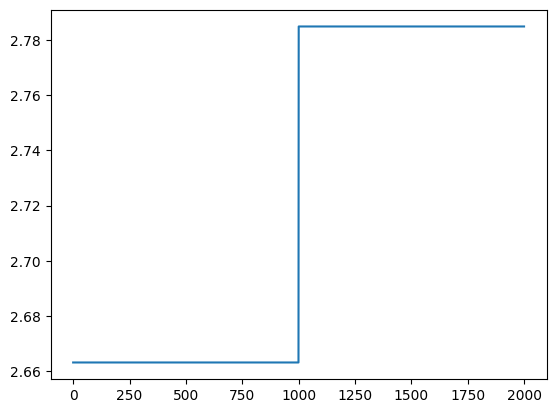

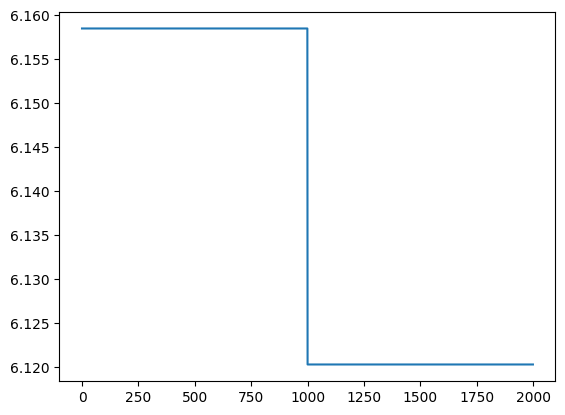

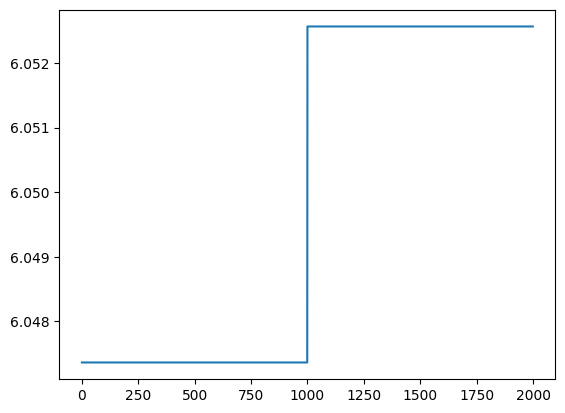

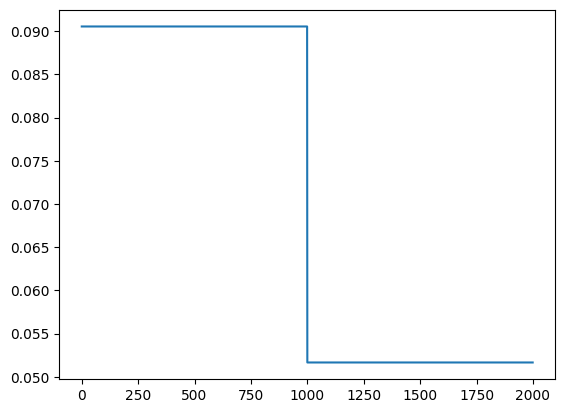

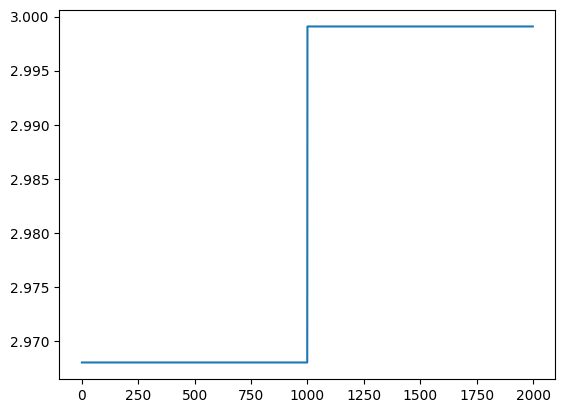

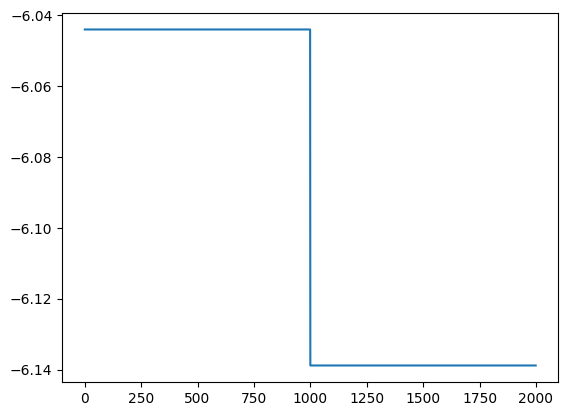

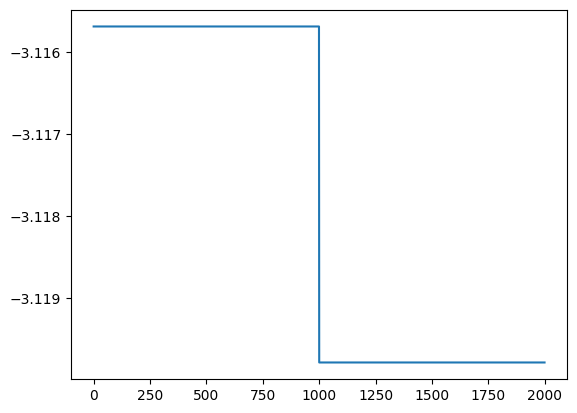

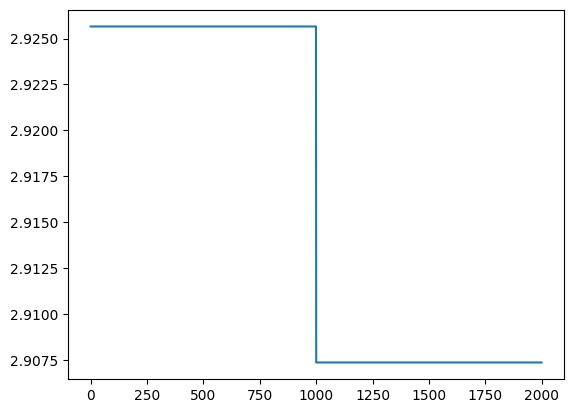

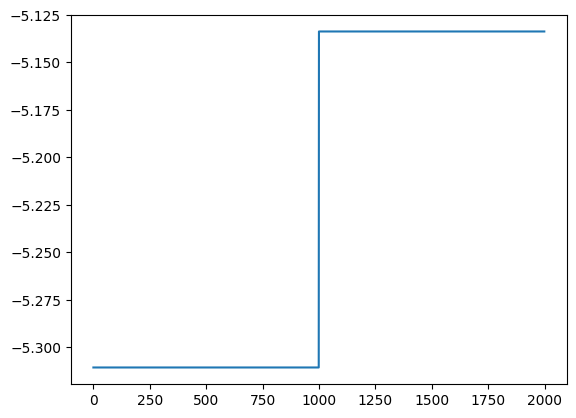

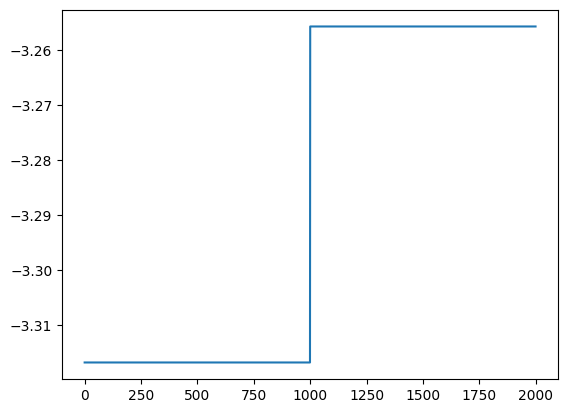

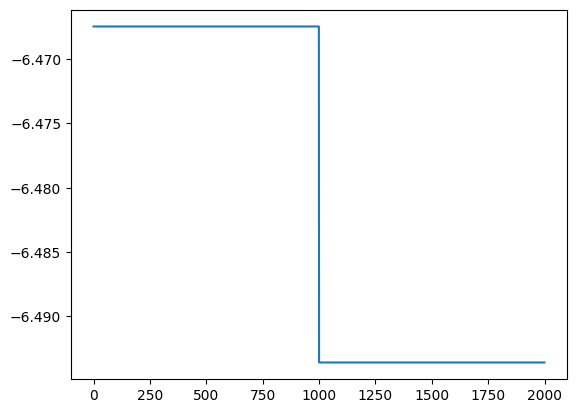

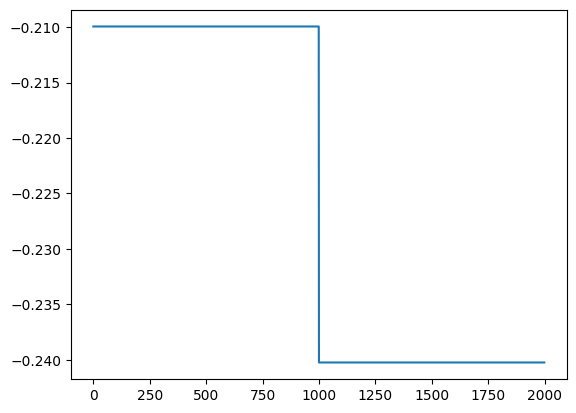

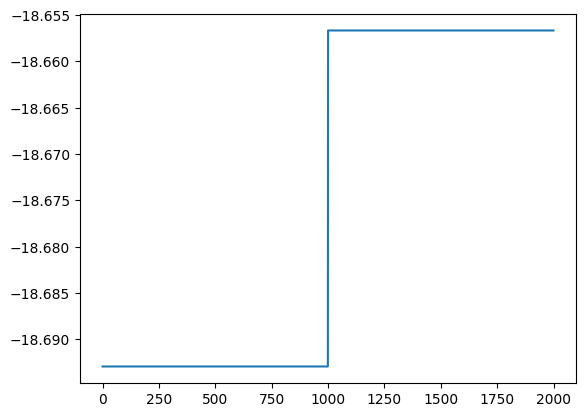

In [20]:
param_arr = np.array(param_list_epoch).transpose()
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()

In [21]:
print(ideal_data[0])

(array([[2.8260362 , 1.3472482 ],
       [2.1470332 , 3.7377877 ],
       [0.11261614, 3.6034775 ],
       [5.438141  , 0.09657113],
       [4.5475364 , 2.6108274 ]], dtype=float32), tensor([ 3.6782e-02+0.0244j,  2.8347e-03-0.0520j, -1.2502e-02+0.0154j,
         2.3145e-02+0.0035j, -2.1539e-03+0.0012j,  2.5525e-03+0.0014j,
        -4.6324e-04-0.0010j, -7.5916e-04+0.0011j, -7.5211e-02+0.0309j,
         7.6336e-02+0.0581j, -1.0550e-02-0.0350j, -2.9314e-02+0.0316j,
         3.3200e-04-0.0046j, -4.8499e-03+0.0024j,  2.0309e-03+0.0003j,
        -8.6033e-04-0.0023j,  2.5940e-01+0.0981j, -5.5077e-02-0.3226j,
        -5.5162e-02+0.1118j,  1.4677e-01-0.0107j, -1.1468e-02+0.0106j,
         1.7664e-02+0.0053j, -4.2574e-03-0.0056j, -3.1487e-03+0.0077j,
        -4.1796e-01+0.2939j,  5.4883e-01+0.2498j, -1.1342e-01-0.1998j,
        -1.3557e-01+0.2348j, -4.3336e-03-0.0285j, -2.6391e-02+0.0214j,
         1.2930e-02-0.0007j, -8.4415e-03-0.0127j], dtype=torch.complex128))
